In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

games = pd.read_csv("Data/games.csv")
plays = pd.read_csv("Data/plays.csv")
players = pd.read_csv("Data/players.csv")
player_play = pd.read_csv("Data/player_play.csv")

week_1 = pd.read_csv("Data/tracking_week_1.csv")
week_2 = pd.read_csv("Data/tracking_week_2.csv")
week_3 = pd.read_csv("Data/tracking_week_3.csv")
week_4 = pd.read_csv("Data/tracking_week_4.csv")
week_5 = pd.read_csv("Data/tracking_week_5.csv")
week_6 = pd.read_csv("Data/tracking_week_6.csv")
week_7 = pd.read_csv("Data/tracking_week_7.csv")
week_8 = pd.read_csv("Data/tracking_week_8.csv")
week_9 = pd.read_csv("Data/tracking_week_9.csv")

tracking = pd.concat([
    week_1, week_2, week_3, week_4, week_5,
    week_6, week_7, week_8, week_9
], ignore_index=True)

print("Data loaded!")
print("Tracking shape:", tracking.shape)
print("Plays shape:", plays.shape)
print("Player info shape:", players.shape)

Data loaded!
Tracking shape: (59327373, 18)
Plays shape: (16124, 50)
Player info shape: (1697, 7)


In [2]:
plays_player_play = pd.merge(
    player_play,
    plays,
    on=["gameId", "playId"],
    how="inner"
)
full_player_data = pd.merge(
    plays_player_play,
    players,
    on="nflId",
    how="left"
)

passing_plays = full_player_data[full_player_data["isDropback"] == True].copy()

defensive_positions = {"CB", "S", "FS", "SS", "OLB", "MLB", "ILB", "DB", "LB", "EDGE"}
defenders = passing_plays[passing_plays["position"].isin(defensive_positions)].copy()

tracking_cols = ["gameId","playId","nflId","frameId","x","y","s","a"]
defenders_tracking = pd.merge(
    defenders[["gameId","playId","nflId","defensiveTeam","position"]],
    tracking[tracking_cols],
    on=["gameId","playId","nflId"],
    how="inner"
)

print("Defenders shape:", defenders.shape)
print("Defenders tracking shape:", defenders_tracking.shape)

Defenders shape: (78017, 104)
Defenders tracking shape: (12891588, 10)


In [3]:
agg_by_position = (
    defenders_tracking
    .groupby(["gameId","playId","defensiveTeam","position"])
    .agg({
        "x": ["mean","std"],
        "y": ["mean","std"],
        "s": ["mean","std"],
        "a": ["mean","std"],
        "nflId": "nunique"
    })
    .reset_index()
)

agg_by_position.columns = [
    "gameId","playId","defensiveTeam","position",
    "x_mean","x_std","y_mean","y_std",
    "s_mean","s_std","a_mean","a_std",
    "count_defenders"
]


In [4]:
position_pivot = agg_by_position.pivot_table(
    index=["gameId","playId","defensiveTeam"],
    columns="position",
    values=["x_mean","x_std","y_mean","y_std","s_mean","s_std","a_mean","a_std","count_defenders"],
    fill_value=0
).reset_index()

position_pivot.columns = [
    f"{col[0]}_{col[1]}" if col[1] else col[0]
    for col in position_pivot.columns
]

print("Pivoted shape:", position_pivot.shape)
position_pivot.head()

Pivoted shape: (9736, 75)


,gameId,playId,defensiveTeam,a_mean_CB,a_mean_DB,a_mean_FS,a_mean_ILB,a_mean_LB,a_mean_MLB,a_mean_OLB,...,y_mean_OLB,y_mean_SS,y_std_CB,y_std_DB,y_std_FS,y_std_ILB,y_std_LB,y_std_MLB,y_std_OLB,y_std_SS
0,2022090800,56,LA,0.892396,0.0,1.349062,1.012396,0.0,0.0,0.000000,...,0.000000,21.404974,14.115580,0.0,1.599621,2.207848,0.0,0.0,0.000000,2.762752
1,2022090800,80,LA,0.811021,0.0,1.398310,1.271162,0.0,0.0,0.000000,...,0.000000,19.371232,15.114276,0.0,2.021260,5.714837,0.0,0.0,0.000000,6.289841
2,2022090800,122,LA,1.087453,0.0,0.000000,0.908933,0.0,0.0,1.050056,...,25.059888,29.695534,11.872820,0.0,0.000000,5.352836,0.0,0.0,3.986406,6.117075
3,2022090800,167,LA,0.889034,0.0,0.000000,1.023793,0.0,0.0,1.202069,...,18.731172,22.860172,12.583700,0.0,0.000000,1.529885,0.0,0.0,0.996065,7.150625
4,2022090800,212,LA,1.272593,0.0,0.000000,1.391901,0.0,0.0,1.427719,...,29.810029,28.834357,10.405388,0.0,0.000000,6.191555,0.0,0.0,6.853585,6.575860


In [5]:
extra_plays_cols = [
    "down",
    "yardsToGo",
    "preSnapHomeScore",
    "preSnapVisitorScore",
    "absoluteYardlineNumber",
    "pff_passCoverage"
]
plays_subset = plays[["gameId","playId","defensiveTeam"] + extra_plays_cols].drop_duplicates()

team_features = pd.merge(
    position_pivot,
    plays_subset,
    on=["gameId","playId","defensiveTeam"],
    how="inner"
)

num_cols = [
    c for c in team_features.columns 
    if c not in ("gameId","playId","defensiveTeam","pff_passCoverage")
]
team_features[num_cols] = team_features[num_cols].fillna(0)

team_features["score_diff"] = team_features["preSnapHomeScore"] - team_features["preSnapVisitorScore"]

team_features = team_features.dropna(subset=["pff_passCoverage"])

print("team_features shape:", team_features.shape)
team_features.head()


team_features shape: (9713, 82)


,gameId,playId,defensiveTeam,a_mean_CB,a_mean_DB,a_mean_FS,a_mean_ILB,a_mean_LB,a_mean_MLB,a_mean_OLB,...,y_std_MLB,y_std_OLB,y_std_SS,down,yardsToGo,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,pff_passCoverage,score_diff
0,2022090800,56,LA,0.892396,0.0,1.349062,1.012396,0.0,0.0,0.000000,...,0.0,0.000000,2.762752,1,10,0,0,85,Cover 6-Left,0
1,2022090800,80,LA,0.811021,0.0,1.398310,1.271162,0.0,0.0,0.000000,...,0.0,0.000000,6.289841,2,4,0,0,79,Cover 6-Left,0
2,2022090800,122,LA,1.087453,0.0,0.000000,0.908933,0.0,0.0,1.050056,...,0.0,3.986406,6.117075,2,3,0,0,65,Cover-3,0
3,2022090800,167,LA,0.889034,0.0,0.000000,1.023793,0.0,0.0,1.202069,...,0.0,0.996065,7.150625,2,8,0,0,57,Cover-3,0
4,2022090800,212,LA,1.272593,0.0,0.000000,1.391901,0.0,0.0,1.427719,...,0.0,6.853585,6.575860,2,9,0,0,44,Cover-1,0


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

le_coverage = LabelEncoder()
team_features["coverage_label"] = le_coverage.fit_transform(
    team_features["pff_passCoverage"].astype(str)
)

exclude_cols = {
    "gameId","playId","defensiveTeam",
    "pff_passCoverage","coverage_label"
}
feature_cols = [c for c in team_features.columns if c not in exclude_cols]

X = team_features[feature_cols].fillna(0)
y = team_features["coverage_label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model_coverage = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=8,
    random_state=42
)
model_coverage.fit(X_train, y_train)

val_probs = model_coverage.predict_proba(X_val)
val_preds = model_coverage.predict(X_val)

acc = accuracy_score(y_val, val_preds)
ll = log_loss(y_val, val_probs, labels=model_coverage.classes_)

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation LogLoss: {ll:.4f}")
print("Coverage Classes:", le_coverage.classes_)


Validation Accuracy: 0.4297
Validation LogLoss: 1.7537
Coverage Classes: ['2-Man' 'Bracket' 'Cover 6-Left' 'Cover-0' 'Cover-1' 'Cover-1 Double'
 'Cover-2' 'Cover-3' 'Cover-3 Cloud Left' 'Cover-3 Cloud Right'
 'Cover-3 Double Cloud' 'Cover-3 Seam' 'Cover-6 Right' 'Goal Line'
 'Miscellaneous' 'Prevent' 'Quarters' 'Red Zone']


In [7]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=18,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

/Users/wyattbellinger/Library/Python/3.10/lib/python/site-packages/xgboost/core.py:158: UserWarning: [21:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.4442


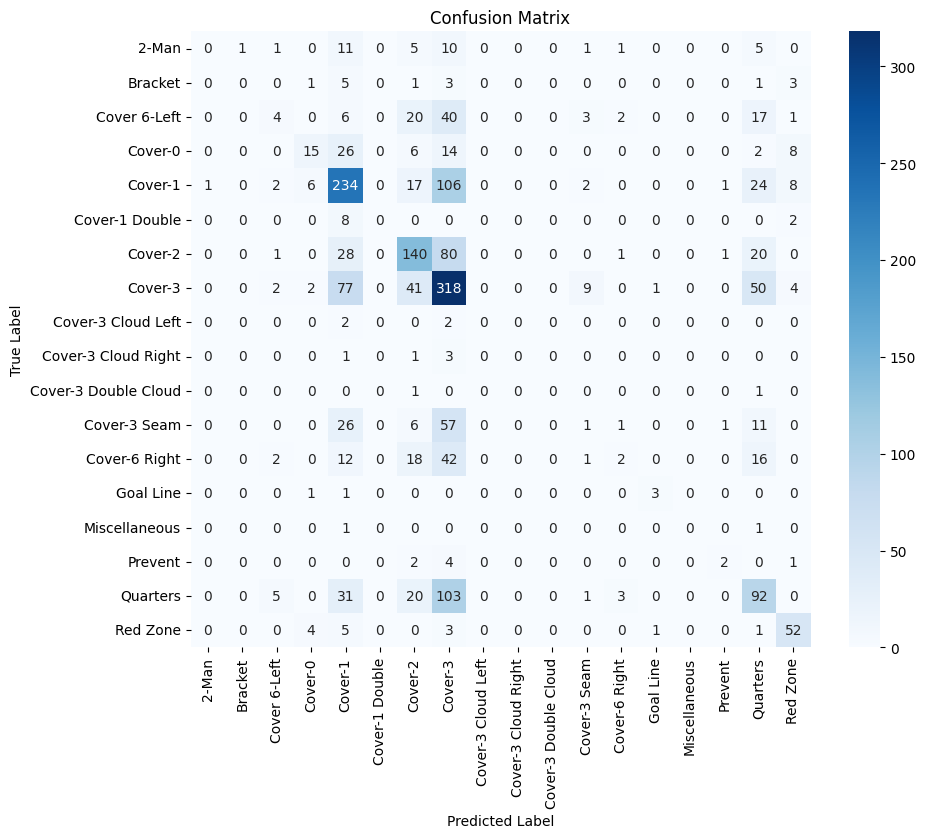

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
labels = le_coverage.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,
    cmap='Blues',
    fmt='g',
    xticklabels=labels,
    yticklabels=labels
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()